# EuroSat-Satellite-CNN-and-ResNet classification

In [ ]:
# 셀 1: 필수 라이브러리 설치 및 임포트
# 최신 버전 torch, torchvision, matplotlib 사용을 권장합니다.
# !pip install torch torchvision matplotlib --upgrade --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 셀 2: EuroSAT 데이터셋 다운로드 및 준비
# torchvision에서 EuroSAT 데이터셋을 제공합니다.

transform = transforms.Compose([
    transforms.Resize((64, 64)),  # EuroSAT 기본 크기
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.3444, 0.3809, 0.3430], std=[0.1596, 0.1238, 0.1597]),
])

train_dataset = datasets.EuroSAT(
    root='./data', download=True, transform=transform
)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=2
)

100%|██████████| 94.3M/94.3M [00:00<00:00, 432MB/s]


EuroSAT 데이터셋을 자동으로 다운로드하고 미리 처리합니다. 데이터 증강은 실습에 따라 추가할 수 있습니다.

Label: PermanentCrop


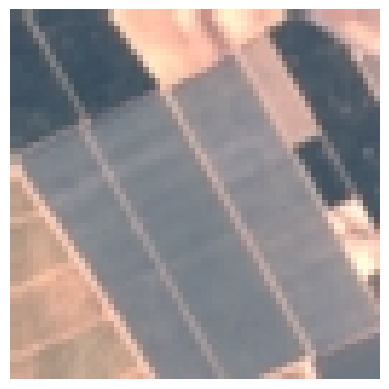

In [ ]:
# 셀 3: 데이터 시각화
# 데이터셋에서 임의의 이미지를 시각화하고 클래스 레이블을 확인합니다.

classes = train_dataset.classes
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.3444, 0.3809, 0.3430])
    std = np.array([0.1596, 0.1238, 0.1597])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

images, labels = next(iter(train_loader))
imshow(images[0])
print(f'Label: {classes[labels[0]]}')

EuroSAT 이미지와 해당 클래스를 시각화하여 데이터의 형태를 이해합니다.

In [ ]:
# 셀 4: CNN 모델 정의 (간단한 구조)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=len(classes)).to(device)

EuroSAT 이미지 분류를 위한 간단한 CNN 모델을 정의합니다.

In [ ]:
# 셀 5: 학습 준비 (손실 함수, 옵티마이저 설정)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

분류 문제에 적합한 손실 함수와 옵티마이저를 설정합니다.

In [ ]:
# 셀 6: 모델 학습 루프

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

Epoch [1/5], Loss: 0.8307, Accuracy: 69.85%
Epoch [2/5], Loss: 0.4783, Accuracy: 82.93%
Epoch [3/5], Loss: 0.3564, Accuracy: 87.40%
Epoch [4/5], Loss: 0.2528, Accuracy: 91.42%
Epoch [5/5], Loss: 0.1840, Accuracy: 93.76%


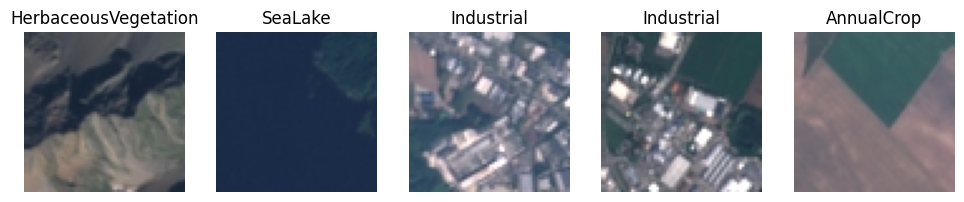

In [ ]:
# 셀 7: 예측 및 결과 시각화

model.eval()
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    imshow(images[i].cpu())
    plt.title(f'{classes[predicted[i]]}')
plt.show()

학습된 모델로 예측을 수행하고, 예측 결과를 이미지와 함께 시각화합니다.

In [ ]:
# 셀 8: ResNet 사용 예시 (최신 torchvision ResNet-18 활용)

from torchvision.models import resnet18

model_resnet = resnet18(weights="IMAGENET1K_V1")
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, len(classes))
model_resnet = model_resnet.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 80.3MB/s]


In [ ]:
# 셀 4: 학습 코드
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%')

Epoch 1/3, Loss: 0.1371, Accuracy: 95.35%
Epoch 2/3, Loss: 0.1069, Accuracy: 96.52%
Epoch 3/3, Loss: 0.0667, Accuracy: 97.83%


ResNet 모델로 데이터셋을 학습합니다. 에폭별 손실과 정확도를 출력합니다.

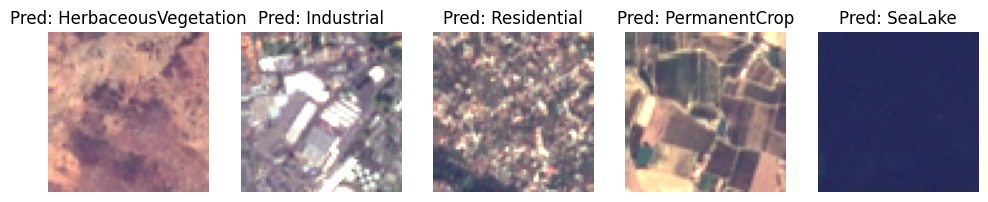

In [ ]:
# 셀 5: 예측 및 시각화 코드
model.eval()
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

plt.figure(figsize=(12, 4))
for i in range(5):
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(f"Pred: {classes[predicted[i]]}")
    plt.axis('off')
plt.show()

학습된 모델로 예측을 수행하고, 결과를 이미지와 함께 시각화합니다.